# 2 qubit GST for XYICZ gate set

In [1]:
# Note: I removed the mGST folders from within the qibocal fork, such that it is installed and updated seperately
from mGST import compatibility,algorithm, optimization, low_level_jit, additional_fns

In [2]:
import pickle as pickle
from pygsti.report import reportables as rptbl #Needs cvxpy!
import pygsti
from argparse import Namespace
import numpy as np
import pandas as pd
import numpy.linalg as la
import json
import matplotlib.pyplot as plt
#from pygsti.modelpacks import smq2Q_XYICNOT as std

%run ../src/mGST/reporting.py

### Setting the parameters

In [3]:
pdim = 4   # physical dimension
r = pdim**2   # rank of the gate superoperators 

max_l = 10  # maximum number of gates in each measurement sequence
n_povm = 4   # number of POVM-elements
d = 6

In [4]:
from true_values import E_true, X_true, rho_true
X_t = X_true[:d].copy()
E_t = E_true.copy()
rho_t = rho_true.copy()
target_mdl = compatibility.arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std') #Save new model with CZ instead of CNOT

### Loading data

In [5]:
# Hardware probabilities
filename = 'data/20230504-1132_cgst_500_5_7_10/20230504-1132_cgst'

with open(filename + '_depth_5.json') as f:
    data = json.load(f)
N = data['nsequences']
l = data['depth']
J5 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])[:,::-1]
y5 = np.array([[data['measurements'][i]['hardware_probabilities'][basis_str] for i in range(N)] for basis_str in ['00','01','10','11']])

with open(filename + '_depth_7.json') as f:
    data = json.load(f)
N = data['nsequences']
l = data['depth']
J7 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])[:,::-1]
y7 = np.array([[data['measurements'][i]['hardware_probabilities'][basis_str] for i in range(N)] for basis_str in ['00','01','10','11']])

with open(filename + '_depth_10.json') as f:
    data = json.load(f)
N = data['nsequences']
l = data['depth']
J10 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])[:,::-1]
y10 = np.array([[data['measurements'][i]['hardware_probabilities'][basis_str] for i in range(N)] for basis_str in ['00','01','10','11']])

J57 = np.concatenate((J5,J7), axis = 0)
y57 = np.concatenate((y5,y7), axis = 1)

J_all = np.concatenate((J57,J10), axis = 0)
y_all = np.concatenate((y57,y10), axis = 1)

meas_samples = data['nshots']

In [6]:
# #Simulation probabilities
# basis_str_dict = {'00':0, '01':1, '10':2, '11':3}
# filename = 'data/20230504-1132_cgst_500_5_7_10/20230504-1132_cgst'

# with open(filename + '_depth_5.json') as f:
#     data = json.load(f)
# N = data['nsequences']
# l = data['depth']
# J5 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])[:,::-1]
# y5 = np.zeros((n_povm,N))
# for i in range(N):
#     keylist = [key for key in data['measurements'][i]['simulation_probabilities'].keys()]
#     for key in data['measurements'][i]['simulation_probabilities'].keys():
#         y5[basis_str_dict[key],i] = data['measurements'][i]['simulation_probabilities'][key]

# with open(filename + '_depth_7.json') as f:
#     data = json.load(f)
# N = data['nsequences']
# l = data['depth']
# J7 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])[:,::-1]
# y7 = np.zeros((n_povm,N))
# for i in range(N):
#     keylist = [key for key in data['measurements'][i]['simulation_probabilities'].keys()]
#     for key in data['measurements'][i]['simulation_probabilities'].keys():
#         y7[basis_str_dict[key],i] = data['measurements'][i]['simulation_probabilities'][key]

# with open(filename + '_depth_10.json') as f:
#     data = json.load(f)
# N = data['nsequences']
# l = data['depth']
# J10 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])[:,::-1]
# y10 = np.zeros((n_povm,N))
# for i in range(N):
#     for key in data['measurements'][i]['simulation_probabilities'].keys():
#         y10[basis_str_dict[key],i] = data['measurements'][i]['simulation_probabilities'][key]

# J57 = np.concatenate((J5,J7), axis = 0)
# y57 = np.concatenate((y5,y7), axis = 1)

# J_all = np.concatenate((J57,J10), axis = 0)
# y_all = np.concatenate((y57,y10), axis = 1)

# meas_samples = data['nshots']

### GST

Starting optimization...
100%|█████████████████████████████████████████| 100/100 [10:19<00:00,  6.20s/it]


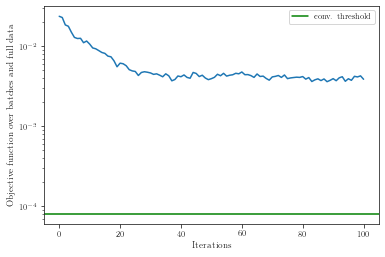

Success threshold not reached, attempting optimization over full data set...
100%|███████████████████████████████████████████| 30/30 [35:04<00:00, 70.15s/it]


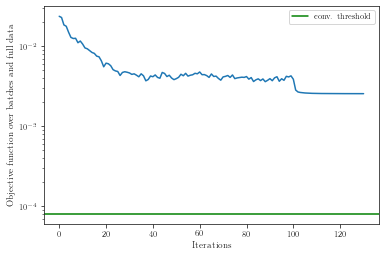

#################
	 Convergence criterion not satisfied, try increasing max_iter or using new initializations.
	 Final objective function value 0.002554592143382346 with # of initializations: 1 
 	 Total runtime: 2724.4912469387054


In [49]:
bsize = 120   # The batch size on which the optimization is started
results = []
rK = 4
for _ in range(1):  
    K_t = additional_fns.Kraus_rep(X_t,d,pdim,rK)
    K,X,E,rho,res_list = algorithm.run_mGST(y_all, J_all, max_l,d,r,rK, n_povm, bsize, meas_samples, method = 'SFN',
                         max_inits = 1, max_iter = 100, final_iter = 30, threshold_multiplier = 5, 
                         target_rel_prec = 1e-5, init = [K_t,E_t,rho_t], testing = True)   
    # K,X,E,rho,res_list = algorithm.run_mGST(y_all,J_all, max_l,d,r,rK, n_povm, bsize, meas_samples, method = 'SFN',
    #                      max_inits = 10, max_iter = 0, final_iter = 30, threshold_multiplier = 500, 
    #                      target_rel_prec = 1e-4, init = [K,E,rho], testing = True)   
    results.append([K,X,E,rho])

In [51]:
###################################### 
filename = 'rank_4_hardware_probs_1132'
parameters = {'sequence length':l,'gate count':d,'Kraus ranks':[4],'phys. dimension':int(np.sqrt(r)), 'Sequence count': N, 
              'J':J_all,'y':y_all, 'target_rel_prec':1e-4}
data_to_safe = {'parameters':parameters, 'results':results}

with open(filename, 'wb') as handle:
    pickle.dump(data_to_safe, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
with open("rank_16_hardware_probs_1132", 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

In [50]:
weights = {'G0': 1, 'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J_all, y_all, target_mdl, gate_labels)

display(s_g), display(s_o)

,F_avg,Diamond distances
Id,"0,97591","0,06193"
Rx(pi/2)[q0],"0,97408","0,11206"
Ry(pi/2)[q0],"0,97816","0,10303"
Rx(pi/2)[q1],"0,97060","0,14595"
Ry(pi/2)[q1],"0,96926","0,14672"
CZ[q0-q1],"0,36861","0,96010"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.002555,0.058268,0.213159,0.118741,0.088207


(None, None)

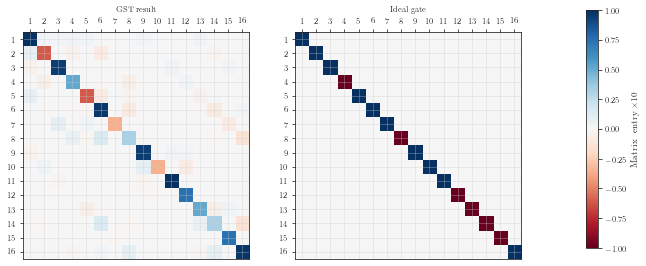

In [48]:
plot_mat(np.real(X_opt[5]), np.real(X_t[5]))

In [9]:
for i in range(20):
    K,X,E,rho = results[i][:]
    weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1}
    gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

    X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)
    df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J57, y57, target_mdl, gate_labels)

    display(s_g), display(s_o)

,F_avg,Diamond distances
Id,"0,99920","0,03915"
Rx(pi/2)[q0],"0,99588","0,09000"
Ry(pi/2)[q0],"0,99575","0,10138"
Rx(pi/2)[q1],"0,99223","0,12235"
Ry(pi/2)[q1],"0,98879","0,14116"
CZ[q0-q1],"0,85641","0,57540"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.003461,0.065201,0.184534,0.654884,0.995346


/home/raphael/.local/lib/python3.8/site-packages/pygsti/tools/optools.py:379: UserWarning: CVXPY failed: Solver 'CVXOPT' failed. Try another solver, or solve with verbose=True for more information. - diamonddist returning -2!
  _warnings.warn("CVXPY failed: %s - diamonddist returning -2!" % str(e))


,F_avg,Diamond distances
Id,"0,99843","0,05573"
Rx(pi/2)[q0],"0,77251","-1,00000"
Ry(pi/2)[q0],"0,68682","0,79272"
Rx(pi/2)[q1],"0,40526","0,99960"
Ry(pi/2)[q1],"0,64461","0,84633"
CZ[q0-q1],"0,67024","0,77951"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.007256,0.121482,0.184534,0.484138,0.458087


,F_avg,Diamond distances
Id,"0,99227","0,11364"
Rx(pi/2)[q0],"0,73937","0,71101"
Ry(pi/2)[q0],"0,75396","0,73739"
Rx(pi/2)[q1],"0,60318","0,88369"
Ry(pi/2)[q1],"0,65274","0,82959"
CZ[q0-q1],"0,57716","0,87067"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.006578,0.115797,0.184534,0.732453,0.925848


,F_avg,Diamond distances
Id,"0,99936","0,03782"
Rx(pi/2)[q0],"0,75354","0,72557"
Ry(pi/2)[q0],"0,71906","0,74063"
Rx(pi/2)[q1],"0,62008","0,87610"
Ry(pi/2)[q1],"0,63091","0,85653"
CZ[q0-q1],"0,64152","0,80400"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.006473,0.114686,0.184534,0.727647,0.919705


/home/raphael/.local/lib/python3.8/site-packages/pygsti/tools/optools.py:379: UserWarning: CVXPY failed: Solver 'CVXOPT' failed. Try another solver, or solve with verbose=True for more information. - diamonddist returning -2!
  _warnings.warn("CVXPY failed: %s - diamonddist returning -2!" % str(e))


,F_avg,Diamond distances
Id,"0,99692","0,07285"
Rx(pi/2)[q0],"0,69020","0,79093"
Ry(pi/2)[q0],"0,68024","0,81564"
Rx(pi/2)[q1],"0,66284","0,79776"
Ry(pi/2)[q1],"0,67190","-1,00000"
CZ[q0-q1],"0,71137","0,72018"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.006655,0.116155,0.184534,0.627451,0.777992


,F_avg,Diamond distances
Id,"0,99930","0,03959"
Rx(pi/2)[q0],"0,70053","0,79491"
Ry(pi/2)[q0],"0,68363","0,80104"
Rx(pi/2)[q1],"0,68914","0,78516"
Ry(pi/2)[q1],"0,73448","0,72923"
CZ[q0-q1],"0,66708","0,78967"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.006473,0.114664,0.184534,0.491837,0.311349


,F_avg,Diamond distances
Id,"0,99922","0,04101"
Rx(pi/2)[q0],"0,75260","0,73297"
Ry(pi/2)[q0],"0,71172","0,73742"
Rx(pi/2)[q1],"0,62269","0,87514"
Ry(pi/2)[q1],"0,63033","0,85837"
CZ[q0-q1],"0,64773","0,79788"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.006477,0.114581,0.184534,0.725439,0.916337


/home/raphael/.local/lib/python3.8/site-packages/pygsti/tools/optools.py:379: UserWarning: CVXPY failed: Solver 'CVXOPT' failed. Try another solver, or solve with verbose=True for more information. - diamonddist returning -2!
  _warnings.warn("CVXPY failed: %s - diamonddist returning -2!" % str(e))


,F_avg,Diamond distances
Id,"0,99797","0,06225"
Rx(pi/2)[q0],"0,77758","-1,00000"
Ry(pi/2)[q0],"0,68796","0,79944"
Rx(pi/2)[q1],"0,50893","0,95251"
Ry(pi/2)[q1],"0,70834","0,74567"
CZ[q0-q1],"0,28557","1,00000"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.007254,0.121568,0.184534,0.481477,0.564890


,F_avg,Diamond distances
Id,"0,99959","0,03086"
Rx(pi/2)[q0],"0,99726","0,06874"
Ry(pi/2)[q0],"0,99677","0,08812"
Rx(pi/2)[q1],"0,20001","1,00000"
Ry(pi/2)[q1],"0,98984","0,13995"
CZ[q0-q1],"0,76863","0,70881"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.002670,0.054409,0.184534,0.657657,0.996071


,F_avg,Diamond distances
Id,"0,99920","0,03919"
Rx(pi/2)[q0],"0,99606","0,08719"
Ry(pi/2)[q0],"0,99672","0,08818"
Rx(pi/2)[q1],"0,99270","0,11631"
Ry(pi/2)[q1],"0,98920","0,14259"
CZ[q0-q1],"0,21036","1,00000"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.003461,0.065205,0.184534,0.607649,0.999314


,F_avg,Diamond distances
Id,"0,99931","0,03931"
Rx(pi/2)[q0],"0,70044","0,79491"
Ry(pi/2)[q0],"0,68380","0,80082"
Rx(pi/2)[q1],"0,68928","0,78507"
Ry(pi/2)[q1],"0,73485","0,72839"
CZ[q0-q1],"0,66726","0,78948"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.006473,0.114696,0.184534,0.491390,0.311788


/home/raphael/.local/lib/python3.8/site-packages/pygsti/tools/optools.py:379: UserWarning: CVXPY failed: Solver 'CVXOPT' failed. Try another solver, or solve with verbose=True for more information. - diamonddist returning -2!
  _warnings.warn("CVXPY failed: %s - diamonddist returning -2!" % str(e))


,F_avg,Diamond distances
Id,"0,99972","0,02453"
Rx(pi/2)[q0],"0,99823","0,05583"
Ry(pi/2)[q0],"0,99815","0,06508"
Rx(pi/2)[q1],"0,20001","-1,00000"
Ry(pi/2)[q1],"0,99185","0,12379"
CZ[q0-q1],"0,57156","0,87575"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.003367,0.065386,0.184534,0.196252,0.085474


/home/raphael/.local/lib/python3.8/site-packages/pygsti/tools/optools.py:379: UserWarning: CVXPY failed: Solver 'CVXOPT' failed. Try another solver, or solve with verbose=True for more information. - diamonddist returning -2!
  _warnings.warn("CVXPY failed: %s - diamonddist returning -2!" % str(e))


,F_avg,Diamond distances
Id,"0,99947","0,03305"
Rx(pi/2)[q0],"0,66563","-1,00000"
Ry(pi/2)[q0],"0,66139","0,83152"
Rx(pi/2)[q1],"0,68775","0,80890"
Ry(pi/2)[q1],"0,74444","0,70353"
CZ[q0-q1],"0,68473","0,74534"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.006685,0.116117,0.184534,0.611104,0.767406


,F_avg,Diamond distances
Id,"0,99882","0,04934"
Rx(pi/2)[q0],"0,70007","0,80166"
Ry(pi/2)[q0],"0,68119","0,79647"
Rx(pi/2)[q1],"0,68966","0,77807"
Ry(pi/2)[q1],"0,73192","0,74024"
CZ[q0-q1],"0,67671","0,77577"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.006484,0.114528,0.184534,0.497353,0.305809


,F_avg,Diamond distances
Id,"0,99959","0,03089"
Rx(pi/2)[q0],"0,20000","1,00000"
Ry(pi/2)[q0],"0,99644","0,09155"
Rx(pi/2)[q1],"0,99249","0,11491"
Ry(pi/2)[q1],"0,99025","0,13773"
CZ[q0-q1],"0,76720","0,71082"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.002670,0.054424,0.184534,0.657913,0.995648


/home/raphael/.local/lib/python3.8/site-packages/pygsti/tools/optools.py:379: UserWarning: CVXPY failed: Solver 'CVXOPT' failed. Try another solver, or solve with verbose=True for more information. - diamonddist returning -2!
  _warnings.warn("CVXPY failed: %s - diamonddist returning -2!" % str(e))


,F_avg,Diamond distances
Id,"0,99888","0,04889"
Rx(pi/2)[q0],"0,63431","0,87081"
Ry(pi/2)[q0],"0,67034","-1,00000"
Rx(pi/2)[q1],"0,69619","0,79981"
Ry(pi/2)[q1],"0,75990","0,68530"
CZ[q0-q1],"0,67939","0,75740"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.006722,0.116476,0.184534,0.595319,0.773038


,F_avg,Diamond distances
Id,"0,99921","0,04279"
Rx(pi/2)[q0],"0,70779","0,78401"
Ry(pi/2)[q0],"0,73614","0,69599"
Rx(pi/2)[q1],"0,68612","0,79417"
Ry(pi/2)[q1],"0,74484","0,68740"
CZ[q0-q1],"0,73873","0,69602"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.008451,0.133990,0.184534,0.606680,0.984248


,F_avg,Diamond distances
Id,"0,99922","0,03886"
Rx(pi/2)[q0],"0,20000","1,00000"
Ry(pi/2)[q0],"0,99639","0,09207"
Rx(pi/2)[q1],"0,99280","0,11861"
Ry(pi/2)[q1],"0,98959","0,13467"
CZ[q0-q1],"0,26031","0,99990"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.003466,0.065298,0.184534,0.191958,0.079744


,F_avg,Diamond distances
Id,"0,99082","0,13857"
Rx(pi/2)[q0],"0,99264","0,12657"
Ry(pi/2)[q0],"0,99139","0,13491"
Rx(pi/2)[q1],"0,43456","0,98280"
Ry(pi/2)[q1],"0,97753","0,20787"
CZ[q0-q1],"0,32688","0,99812"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.006249,0.108777,0.184534,0.230474,0.125406


,F_avg,Diamond distances
Id,"0,99799","0,06149"
Rx(pi/2)[q0],"0,75125","0,74095"
Ry(pi/2)[q0],"0,70268","0,73168"
Rx(pi/2)[q1],"0,62443","0,87504"
Ry(pi/2)[q1],"0,62668","0,86364"
CZ[q0-q1],"0,66577","0,77783"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.006496,0.114643,0.184534,0.722223,0.918406


In [31]:
s0 = np.array([[1,0],[0,1]]).astype(np.complex128)
s1 = np.array([[0,1],[1,0]]).astype(np.complex128)

unitary_part = np.kron(s0,s1)
K_XI = np.array([unitary_part])
X_XI = np.einsum('jkl,jnm -> knlm', K_XI, K_XI.conj()).reshape(16,16)

rho_test = X_XI@rho_opt
E_test = E_opt@X_XI

X_test = np.einsum('ij,kjl, lm -> kim', X_XI, X_opt, X_XI)

In [33]:
df_g, df_o, s_g, s_o = report(X_test, E_test, rho_test, J_all, y_all, target_mdl, gate_labels)
display(s_g), display(s_o)

,F_avg,Diamond distances
Id,"0,99968","0,02508"
Rx(pi/2)[q0],"0,99863","0,05415"
Ry(pi/2)[q0],"0,20000","1,00000"
Rx(pi/2)[q1],"0,98921","0,15704"
Ry(pi/2)[q1],"0,98916","0,15859"
CZ[q0-q1],"0,53933","0,91906"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.004754,0.084002,0.213159,0.173636,0.130938


(None, None)

Assignment fidelity for ideal basis state 0: 0.008842046328310644


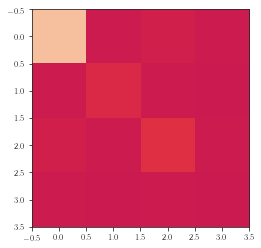

Assignment fidelity for ideal basis state 1: 0.040880325116652017


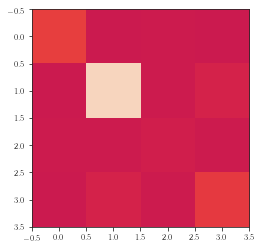

Assignment fidelity for ideal basis state 2: 0.005588059086874302


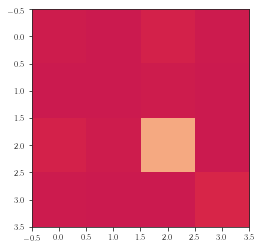

Assignment fidelity for ideal basis state 3: 0.031889205161084656


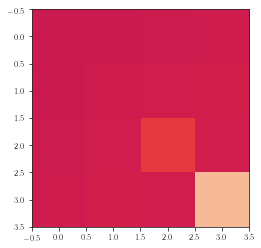

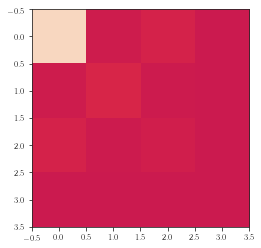

In [30]:
for i in range(4):
    print("Assignment fidelity for ideal basis state %i:"%i, np.abs(E_opt.reshape(4,4,4)[i,i,i])**2)
    plt.imshow(np.abs(E_test.reshape(4,4,4)[i,:,:]), vmin = -1, vmax = 1)
    plt.show()
plt.imshow(np.abs(rho_test.reshape(4,4)), vmin = -1, vmax = 1)
plt.show()

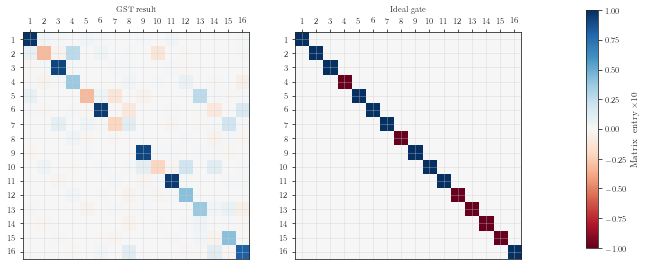

In [17]:
plot_mat(np.real(X_opt[5]), np.real(X_t[5]))

In [31]:
print(low_level_jit.objf(X_t,E_t,rho_t, J57,y57))
print(low_level_jit.objf(X,E,rho, J57,y57))

print(MVE_data(X_t,E_t,rho_t,J57,y57))
print(MVE_data(X,E,rho,J57,y57))

0.014011978719999998
0.006073570611499048
(0.04869140000000004, 0.9999999999999996)
(0.06940252767888164, 0.8310980722743345)


### Rank 1 simulated probabilities

In [16]:
with open("rank_1_from_simulated_probs_10_runs", 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

In [17]:
K,X,E,rho = results[0][:]

weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J_all, y_all, target_mdl, gate_labels)

display(s_g), display(s_o)

,F_avg,Diamond distances
Id,"0,99949","0,03319"
Rx(pi/2)[q0],"0,99820","0,06403"
Ry(pi/2)[q0],"0,99900","0,04718"
Rx(pi/2)[q1],"0,99971","0,02557"
Ry(pi/2)[q1],"0,99838","0,05821"
CNOT[q0-q1],"0,39986","1,00000"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.015486,0.114983,0.067022,0.069527,0.050744


(None, None)

In [19]:
K_opt = additional_fns.Kraus_rep(X_opt,d,pdim,1)

In [24]:
print(K_opt[5][0])

[[ 9.99902406e-01+0.j          7.72218298e-03-0.00112471j
   6.10650425e-03+0.00148481j  2.13288414e-03+0.00949943j]
 [-7.69238823e-03-0.00108898j  9.99667441e-01+0.01870522j
  -7.23669189e-04-0.00633907j  1.44135717e-02-0.00251073j]
 [-6.43502858e-03+0.00122854j  1.02734539e-03-0.0065589j
   9.96951196e-01+0.07254474j  1.92235383e-02+0.01921029j]
 [-2.52830798e-03+0.00924713j -1.40736113e-02-0.00347602j
  -2.17165799e-02+0.01654575j  9.97386961e-01+0.06458968j]]


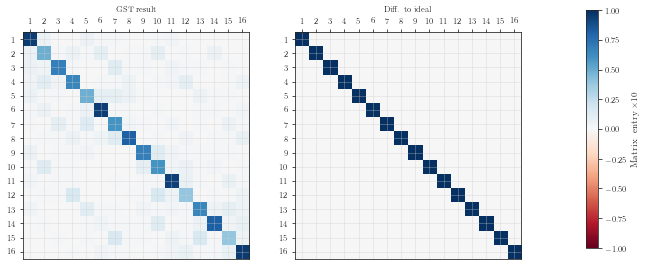

In [14]:
plot_mat(np.abs(X_opt[5]), np.abs(X_t[5]))

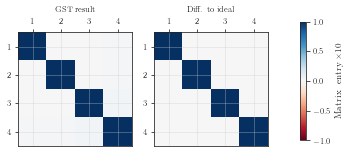

In [20]:
plot_mat(np.abs(K_opt[5][0]), np.abs(K_t[5][0]))

0.0
0.018709264318632915
0.0726385668382582
0.06466860096608343


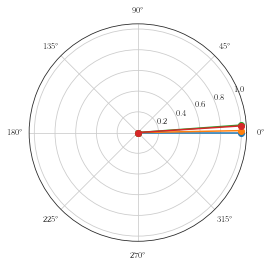

In [21]:
for x in np.diag(K_opt[5][0]):
    print(np.angle(x))
    plt.polar([0,np.angle(x)],[0,abs(x)],marker='o')
plt.show()

# Analysis

### Full rank

In [9]:
with open("rank_16_from_init_hardware_probs_1132", 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

In [10]:
K,X,E,rho = results[0][:]

weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J_all, y_all, target_mdl, gate_labels)

display(s_g), display(s_o)

,F_avg,Diamond distances
Id,"0,99981","0,01886"
Rx(pi/2)[q0],"0,99736","0,06978"
Ry(pi/2)[q0],"0,99380","0,07097"
Rx(pi/2)[q1],"0,97579","0,14862"
Ry(pi/2)[q1],"0,96966","0,13100"
CZ[q0-q1],"0,40950","0,95475"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.004100,0.081282,0.221379,0.119560,0.082728


(None, None)

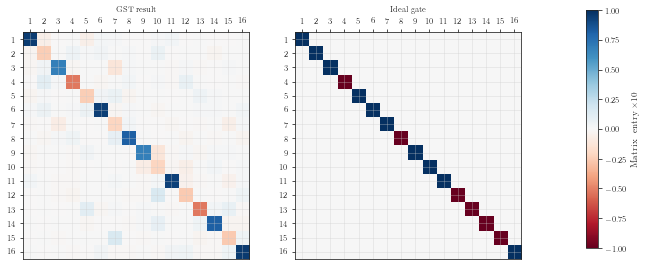

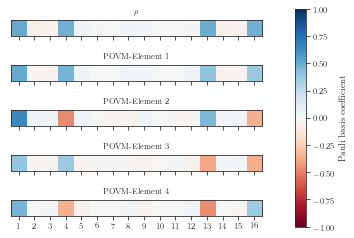

In [11]:
gate_index = 5

X_opt_pp, E_opt_pp, rho_opt_pp = compatibility.std2pp(X_opt,E_opt,rho_opt)
X_t_pp, E_t_pp, rho_t_pp = compatibility.pygsti_model_to_arrays(target_mdl,basis = 'pp')


plot_mat(X_opt[gate_index], X_t[gate_index])
plot_spam(rho_opt_pp, E_opt_pp)

Assignment fidelity for ideal basis state 0: 0.7140673549515567


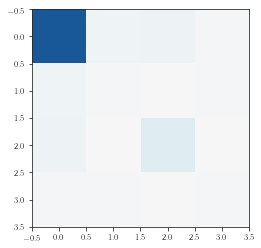

Assignment fidelity for ideal basis state 1: 0.8481359951816153


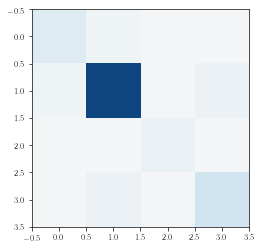

Assignment fidelity for ideal basis state 2: 0.46355187369719203


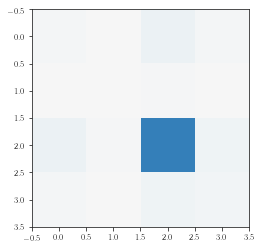

Assignment fidelity for ideal basis state 3: 0.5684939969097486


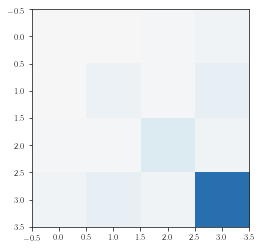

In [28]:
for i in range(4):
    print("Assignment fidelity for ideal basis state %i:"%i, np.abs(E_opt.reshape(4,4,4)[i,i,i])**2)
    plt.imshow(np.abs(E_opt.reshape(4,4,4)[i,:,:]), vmin = -1, vmax = 1)
    plt.show()

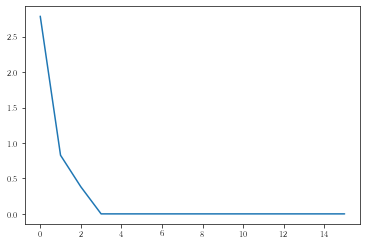

In [15]:
# Spectrum of the Choi matrix
X_choi = X_opt.reshape(d,pdim,pdim,pdim,pdim)
X_choi = np.einsum('ijklm->iljmk',X_choi).reshape(d,pdim**2,pdim**2)
plt.plot(np.sort(np.abs(la.eig(X_choi[5])[0]))[::-1])

In [18]:
from qiskit.quantum_info import entanglement_of_formation

plus_plus = np.outer(np.array([1,1,1,1])/2,np.array([1,1,1,1])/2).reshape(-1)

print(entanglement_of_formation((X_opt[5]@plus_plus).reshape(4,4)))

0.012591550652701854


### Rank 4

In [19]:
with open("ranks_4_from_init", 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

In [20]:
K,X,E,rho = results[0][:]

weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J_all, y_all, target_mdl, gate_labels)

display(s_g), display(s_o)

,F_avg,Diamond distances
Id,"0,98466","0,04937"
Rx(pi/2)[q0],"0,97724","0,08978"
Ry(pi/2)[q0],"0,97419","0,09854"
Rx(pi/2)[q1],"0,94845","0,16368"
Ry(pi/2)[q1],"0,95050","0,14989"
CNOT[q0-q1],"0,37837","0,94874"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.003927,0.079855,0.221379,0.699667,0.997707


(None, None)

### Rank 1

In [15]:
with open("rank_1_from_init_hardware_probs_1132", 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

In [16]:
K,X,E,rho = results[0][:]

weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J_all, y_all, target_mdl, gate_labels)

display(s_g), display(s_o)

,F_avg,Diamond distances
Id,"0,99892","0,04798"
Rx(pi/2)[q0],"0,99901","0,04744"
Ry(pi/2)[q0],"0,99632","0,08398"
Rx(pi/2)[q1],"0,99120","0,11652"
Ry(pi/2)[q1],"0,99138","0,12533"
CZ[q0-q1],"0,33972","1,00000"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.006186,0.102388,0.221379,0.159434,0.187492


(None, None)

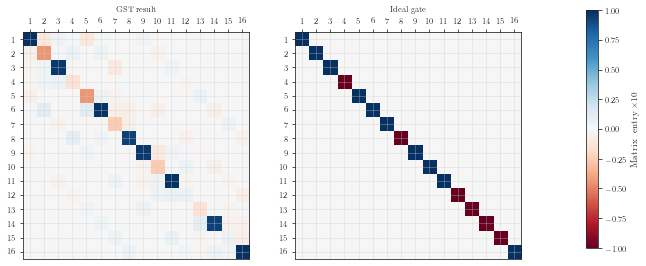

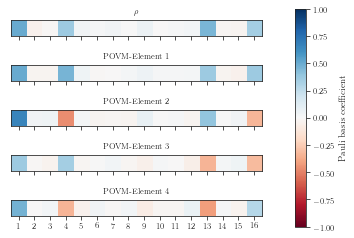

In [17]:
gate_index = 5

X_opt_pp, E_opt_pp, rho_opt_pp = compatibility.std2pp(X_opt,E_opt,rho_opt)
X_t_pp, E_t_pp, rho_t_pp = compatibility.pygsti_model_to_arrays(target_mdl,basis = 'pp')


plot_mat(X_opt[gate_index], X_t[gate_index])
plot_spam(rho_opt_pp, E_opt_pp)

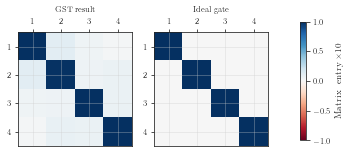

In [18]:
K_opt = additional_fns.Kraus_rep(X_opt,d,pdim,1)
plot_mat(np.abs(K_opt[5][0]), np.abs(K_t[5][0]))

0.0
-2.038862400550034
-0.2046547625025989
-1.71935384831613


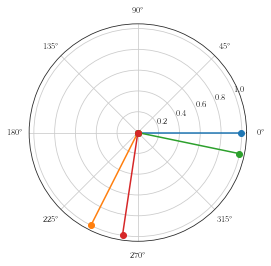

In [19]:
for x in np.diag(K_opt[5][0]):
    print(np.angle(x))
    plt.polar([0,np.angle(x)],[0,abs(x)],marker='o')
plt.show()

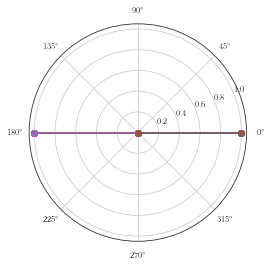

In [20]:
for x in np.diag(X_t[5]):
    plt.polar([0,np.angle(x)],[0,abs(x)],marker='o')
plt.show()